<a href="https://colab.research.google.com/github/DaudRaza-NUST/DL-Project/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> OBJECT DETECTION </center>
### <center> ROBOFLOW GAME DATASET </center>

### Section 1: Exploring the Dataset

Importing Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

2023-12-09 12:29:11.549380: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 12:29:11.959335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 12:29:11.960031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 12:29:12.048880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 12:29:12.273232: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 12:29:12.284699: I tensorflow/core/platform/cpu_feature_guard.cc:1

Importing the Roboflow Game Dataset. The Dataset consists of 9.7k images, split into 88% training data, 7% validation data, and 5% testing data. The data has been ported over in the COCO format, which includes the annotations in JSON file format. In order to import the training data, we will use the pycoco API.

In [22]:
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import cv2 as cv

The File has to be opened in the 'Task 1-Object Detection' Folder to work correctly 
 

In [6]:
train = COCO('Dataset/train/_annotations.coco.json')

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


Checking what categories exist in the dataset

In [7]:
cats = train.loadCats(train.getCatIds())

names = [cat['name'] for cat in cats]
print(f"{len(cats)} categories: \n{', '.join(names)}")

6 categories: 
deer-hog, Coyote, Deer, Hog, Rabbit, Raccoon


There are a total of 6 Categories present in the dataset. 
1. Deer-hog
2. Coyote
3. Deer
4. Hog
5. Rabbit
6. Raccoon

In [12]:
# Class Ids
catIds = train.getCatIds()

# Get image Ids
imgIds = train.getImgIds()

# Load images
images = train.loadImgs(imgIds)

print(len(imgIds))
print("imgIds: ", imgIds[0])
print("images: ", images[0])


8453
imgIds:  0
images:  {'id': 0, 'license': 1, 'file_name': '2297271f-4db5-46aa-b92f-efc6a41e19b9_jpg.rf.0003b4e66a75bb5f34b4c94e1cd46e86.jpg', 'height': 430, 'width': 552, 'date_captured': '2023-10-25T23:14:41+00:00'}


The images contain the following information:
1. id
2. license
3. file_name
4. height
5. width
6. date_captured

Now, we import the images themselves in order to better understand the data visually.

In [26]:
img_folder = 'Dataset/train/'
train_imgs = []
for img in images:
    img_path = img_folder + img['file_name']
    train_imgs.append(Image.open(img_path))

(<matplotlib.image.AxesImage at 0x7f1861f873d0>, (-0.5, 589.5, 457.5, -0.5))

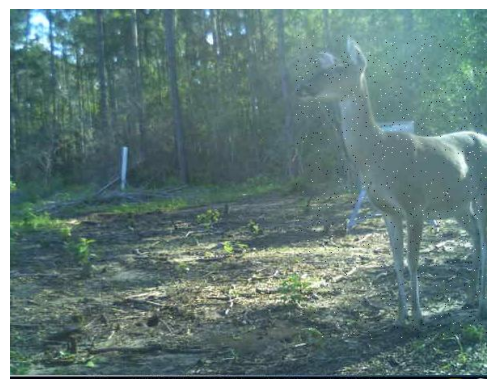

In [35]:
rand_img = images[np.random.randint(0, len(imgIds))]
im = cv.imread(img_folder + rand_img['file_name'])
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im), plt.axis('off')

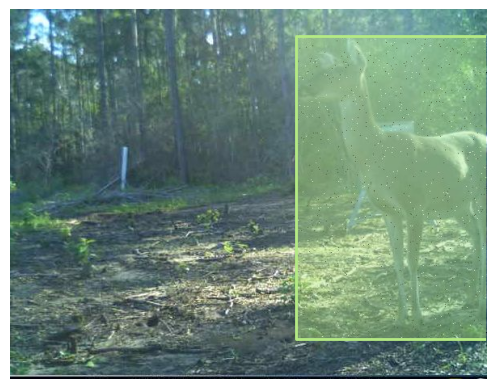

In [36]:
plt.imshow(im); plt.axis('off')
annIds = train.getAnnIds(imgIds=rand_img['id'], iscrowd=None)
anns = train.loadAnns(annIds)
train.showAnns(anns, draw_bbox=True)